In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.signal as signal
import bitarray
from fixedpoint import FixedPoint
import random

NOTE: If you're going to change any constants, make sure to read the NOTE sections.

# 802.15.4 Simulation

This simulation is meant to test the whole 802.15.4 chain from raw packet through radio and back. Everything is discretized and written for easy transition to RTL. Most of the analog level code is copied from <code>rfsim.ipynb</code>. Refer to it for more information.

In [2]:
F_CR  = 100e6 # lower freq for easier computation, same math
F_DF  = 500e3 # 500kHz deviation max
F_IF  = 2e6   # 2MHz
F_ADC = 32e6  # 32Msamples/s

F_SR  = 1e6   # 1MSym/s
F_DEV = 500e3 # 500kHz

FS_CR = 16 * F_CR # oversample for that smoothness

## TX Chain

Analog RF provides us a 6-bit LUT to indicate the desired FM deviation away from the carrier. We'll need 500kHz deviation for 802.15.4 and 250kHz for BLE. The LUT can be calibrated in software. We'll index it as a 6-bit fixed point where 0b10000 (-1.0) is -500kHz and 0b011111 (0.96875) is 500kHz. Note that this value should be software configurable since the LUT could change.

NOTE: SNR noise are correct for 802.15.4 only (depends on bandwidth of signal). Constants need to change for other modulations and sample rates since noise energy is spread across the entire spectrum while our signal is concentrated. There's a way to dynamically compute the right constants but not worth it right now.

In [3]:
LUT_BITS = 6
LUT_M = 1 # number of integer bits (MSB is negative)
LUT_N = 5 # number of fractional bits

# NOTE: experimentally found for 16*100MHz RF sample rate and 802.15.4
SNR0 = 27 # SNR of signal with unscaled np.random.normal

In [4]:
def rf_mod(data, fs, SNR=25.0):
    """
    Performs CPFSK on a sequence of desired deviations
    
    Parameters:
    data: array of FixedPoint
    fs: sample rate in Hz of data array
    SNR: desired SNR in dB
    
    Returns:
    ts: timestamp in seconds for each in sample
    ys: value of signal
    """
    # create LUT (doesn't need to be linear)
    LUT = np.linspace(-F_DF, F_DF, num=2**LUT_BITS)
    LUT = np.hstack((LUT[2**(LUT_BITS-1):], LUT[:2**(LUT_BITS-1)]))
    
    # ensure that bits are right format and "cast" to int for LUT indexing
    [d.resize(LUT_M, LUT_N) for d in data]
    data = np.array([LUT[d.bits] for d in data])
    
    # duplicate points (like a zero-order hold DAC)
    n_samples = int(len(data)*FS_CR/fs)
    data = np.kron(data, np.ones(n_samples//len(data)))
    
    # frequency modulate
    dt = 1/FS_CR
    ts = np.r_[0:n_samples]*dt
    theta = 2*np.pi*(F_CR*ts + np.cumsum(data)*dt)
    ys = np.sin(theta)
    
    # add noise
    P = SNR0 - SNR # gain for noise in dB
    n = 10**(P/20) * np.random.normal(size=ys.shape)
    ys = ys + n
    
    return ts, ys

The following function modulates a raw chipstream with OQPSK-HSS by equivalently doing MSK with a special transform. This is intended to be used with 32-chip sequences.

In [5]:
def oqpsk_mod(data, SNR=25.0):
    """
    Modulates bitstream given by data, LSB first
    
    Parameters:
    data: byte-string
    SNR: noise to pass to rf_mod
    
    Returns:
    ts: timestamps for each sample
    sig: samples of the modulated RF signal
    """
    # convert to bitstream
    bs = bitarray.bitarray(endian="little")
    bs.frombytes(data)
    
    # constants to send to LUT
    pd = FixedPoint( F_DEV / F_DF, signed=1,m=LUT_M,n=LUT_N, overflow_alert="ignore")
    nd = FixedPoint(-F_DEV / F_DF, signed=1,m=LUT_M,n=LUT_N, overflow_alert="ignore")
    
    # arbitrarily start at 0 for Q
    msk_data = [0]*(len(bs)+1)
    I, Q = 0, 0
    for i, b in enumerate(bs):
        if i%2==0:
            I = b
            k = not (I^Q)
        else:
            Q = b
            k = (I^Q)
        msk_data[i] = pd if k else nd
    msk_data[-1] = msk_data[-2] # transmit last bit for a full symbol period
    
    # modulate bitstream
    ts, sig = rf_mod(msk_data, 2*F_SR, SNR=SNR)
    return ts, sig

References:
- https://scdn.rohde-schwarz.com/ur/pws/dl_downloads/dl_application/application_notes/1gp105/1GP105_1E_Generation_of_IEEE_802154_Signals.pdf
- https://www.mathworks.com/help/comm/ug/end-to-end-ieee-802-15-4-phy-simulation.html

The following function converts a packet to a chipstream and modulates it. The spec is not 100% clear how to index into the symbol-to-chip table (which side is the MSB?) but based on the MATLAB example it appears to be the normal way with b3 or b7 being the MSB.

TODO look into converting O-QPSK chip sequences directly into MSK sequences so it becomes a one-step process. Currently TX implementation doesn't do this.

In [6]:
def lrwpan_mod(data, SHR=True, PHR=True, SNR=25.0):
    """
    Modulates an 802.15.4 packet containing data
    
    Parameters:
    data: packet to send, keep < 127 bytes
    SHR: prepend the SHR (preamble) or not
    PHR: prepend the PHR (packet length) or not
    SNR: SNR to pass to rf_mod
    
    Returns:
    ts: timestamps for each sample
    sig: samples of the modulated RF signal
    """
    # generate symbol-to-chip LUT but reversed from the table in spec bc LSB at right
    LUT = [
        0b01110100010010101100001110011011,
        0b01000100101011000011100110110111,
        0b01001010110000111001101101110100,
        0b10101100001110011011011101000100,
        0b11000011100110110111010001001010,
        0b00111001101101110100010010101100,
        0b10011011011101000100101011000011,
        0b10110111010001001010110000111001,
        0b11011110111000000110100100110001,
        0b11101110000001101001001100011101,
        0b11100000011010010011000111011110,
        0b00000110100100110001110111101110,
        0b01101001001100011101111011100000,
        0b10010011000111011110111000000110,
        0b00110001110111101110000001101001,
        0b00011101111011100000011010010011,
    ]
    LUT = [l.to_bytes(4, "little") for l in LUT]
    
    if PHR:
        data = len(data).to_bytes(1, "little") + data
    
    if SHR:
        data = b"\x00\x00\x00\x00\xA7" + data
        
    cs = b""
    for b in data:
        cs = cs + LUT[b & 0x0F] # lower 4 bits
        cs = cs + LUT[(b >> 4) & 0x0F] # upper 4 bits
    
    return oqpsk_mod(cs, SNR=SNR)

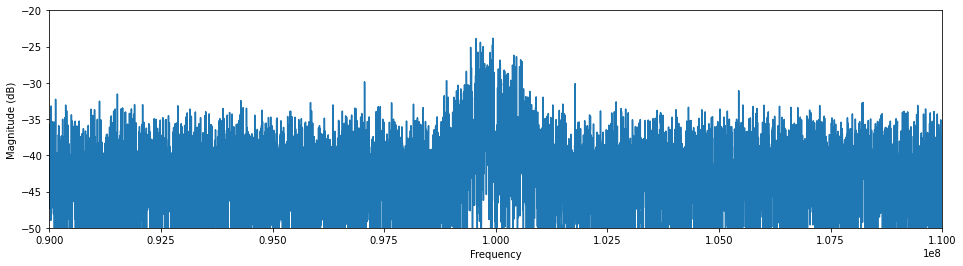

In [7]:
SNR = 10
ts, sig = lrwpan_mod(b'hello world!', SNR=SNR)

# channels have bandwidth of 2MHz and are 5MHz apart
plt.figure(figsize=(16,4))
plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-10e6,F_CR+10e6])
plt.ylim([-50, -20])
plt.show()

## RX Chain

Analog RF provides us 8-bit signed ADC readings where 0x80 is -1 and 0x7F is +1 (actually 0.9921875 but that shouldn't matter). We can directly convert these to an 8-bit signed fixed point number for DSP.

In [8]:
ADC_BITS = 8
ADC_M = 1
ADC_N = 7

In [9]:
def rf_demod(sig, ps=0):
    """
    Demodulates I/Q signals from F_CR to F_IF and ADC samples. This step is done in analog RF.
    
    Parameters:
    sig: raw RF signal sampled as FS_CR
    ps: phase offset for LO
    
    Returns:
    ts: timestamps for each sample meant for plotting
    I: raw I samples from ADC
    Q: raw Q samples from ADC
    """
    # generate the LO mixing signals
    F_LO = F_CR - F_IF
    dt = 1/FS_CR
    ts = np.r_[0:len(sig)]*dt
    I_lo = np.sin(2*np.pi*F_LO*ts - ps)
    Q_lo = np.sin(2*np.pi*F_LO*ts - np.pi/2 - ps)
    
    # mix!
    I = sig*I_lo
    Q = sig*Q_lo
    
    # filter out (~twice) the carrier (well into cutoff freq of amplifiers)
    lpf_b, lpf_a = signal.butter(16, F_CR, fs=FS_CR)
    I = signal.filtfilt(lpf_b, lpf_a, I)
    Q = signal.filtfilt(lpf_b, lpf_a, Q)
    
    # downsample to ADC
    n_samples = int(len(sig)*F_ADC/FS_CR)
    ts = np.r_[0:n_samples]*1/F_ADC
    I  = signal.resample(I, n_samples)
    Q  = signal.resample(Q, n_samples)
    
    # BPF I/Q by 2*F_DF on either side of F_IF (~40dB/decade)
    bpf_b, bpf_a = signal.butter(1, [F_IF-2*F_DF, F_IF+2*F_DF], btype="bandpass", fs=F_ADC)
    I = signal.filtfilt(bpf_b, bpf_a, I)
    Q = signal.filtfilt(bpf_b, bpf_a, Q)
    
    # AGC to just below saturation
    m = max(np.max(I), np.max(Q), -np.min(I), -np.min(Q))
    I = I / m * 0.98
    Q = Q / m * 0.98
    
    # discretize points (handoff to digital RF)
    I = [FixedPoint(i,signed=1,m=ADC_M,n=ADC_N) for i in I]
    Q = [FixedPoint(q,signed=1,m=ADC_M,n=ADC_N) for q in Q]
    
    return ts, I, Q

Here's some helpers to apply filters.

In [10]:
def apply_fir(b, x):
    """
    Implements y[n] = b[0]*x[n] + b[1]*x[n-1] + ...
    
    Parameters:
    b: filter coefficients
    x: signal to filter as an array of FixedPoint
    
    Returns:
    y: filtered signal
    """
    xm, xn = x[0].m, x[0].n # FixedPoint likes to grow...
    px = x + [0]*(len(b)-1) # pad with zeros
    y = [0]*len(x)
    for n in range(len(x)):
        y[n] = 0
        for i in range(len(b)):
            y[n] += b[i] * px[n-i]
        y[n].resize(xm, xn) # should technically resize after each calc, but slower
    
    return y

### Image Rejection

Reference: https://en.wikipedia.org/wiki/Hilbert_transform#Discrete_Hilbert_transform

For image rejection, we use a Hilbert filter. Last year's team used 10-bit signed fixed point with a length 29 FIR filter. To create the FIR filter, we essentially have $h[n]=\frac{2}{\pi n}$ and just shift it to make it causal. This does cause a time delay in our filtered signal, so we have to delay the other signal (by half the length of the Hilbert filter) to match. Due to available hardware area, we ended up implementing the delay as an FIR filter for maximum flexibility.

In [11]:
IMG_BITS = 16
IMG_M = 4
IMG_N = 12

In [12]:
def image_reject(I, Q):
    """
    Uses the Q signal to image reject the I signal
    
    Parameters:
    I: I signal
    Q: Q signal
    
    Returns:
    sig: image rejected signal
    """
    # design filter
    N = 29 # length of filter
    
    ns = np.r_[-(N-1)//2:(N-1)//2+1]
    hilbert_b = [(0 if n%2==0 else 2/np.pi/n) for n in ns] # TODO window?
    hilbert_b = [FixedPoint(c,signed=1,m=IMG_M,n=IMG_N) for c in hilbert_b]
    
    # scale to same fixed point size
    [i.resize(IMG_M, IMG_N) for i in I]
    [q.resize(IMG_M, IMG_N) for q in Q]
    
    # apply filter, delaying I as needed (in this case by truncating Q)
    Qh = apply_fir(hilbert_b, Q)
    I, Qh = I[:-(N-1)//2], Qh[(N-1)//2:] # "delay" I to line up with Q
    sig = [i+q for i,q in zip(I, Qh)]
    sig += [0]*((N-1)//2) # pad back to same length
    
    return sig

### MSK Demodulation

From here, we can perform demodulation on the raw ADC samples to generate an oversampled chipstream. The FixedPoint is at risk of saturation if the filters are too long, so double check that they stay below the limit.

#### Previous Solutions

Last year's team used bandpass filtering followed by envelope detection. For BLE transmitting at 1.75MHz or 2.25MHz, we have more than a cycle of each frequency per bit period to have confidence in our decision. FIR filters for that linear phase delay to lower ISI.

The Single Chip Mote used matched filtering. It used two templates for each frequency phase-shifted by 90° to account for phase shifts.

#### Current Solution

We use a matched filter which empirically performed slightly better than the bandpass/envelope method. The implementation actually ends up being really similar. The "FIR filters" are the samples of the desired frequency of length equal to a bit period. The difference is we now have two filters for each frequency to account for phase shift. We still square each filter output (and sum the two for a frequency) to determine the "strength" of a frequency and lowpass filter afterwards.

NOTE: The matched filters should be scaled to keep the filter output <1 (to avoid saturating the FixedPoint) and is manually done (should be relatively easy to compute the correct scalar). Our relatively conservative method considers the maximum output of a filter to be the square of the dot product of the filter with a normal sine/cosine scaled to 2x (Hilbert filter doubles our signal).

In [13]:
DEMOD_BITS = 16
DEMOD_M = 4
DEMOD_N = 12

In [14]:
def oqpsk_demod(sig, ps=0):
    """
    Generates an oversampled MSK chipstream from an RF signal
    
    Parameters:
    sig: raw RF signal
    ps: phase offset for LO
    
    Returns:
    chips: oversampled chipstream
    """
    # design "filters"
    SPC = int(F_ADC/F_SR/2)
    dt = 1/F_ADC
    ts = np.r_[0:SPC]*dt
    
    # scaled so filter output <1
    s0_b = np.sin(2*np.pi*(F_IF-F_DEV)*ts) / 16
    c0_b = np.cos(2*np.pi*(F_IF-F_DEV)*ts) / 16
    s1_b = np.sin(2*np.pi*(F_IF+F_DEV)*ts) / 16
    c1_b = np.cos(2*np.pi*(F_IF+F_DEV)*ts) / 16
    lpf_b = signal.firwin(21, 2*F_SR, pass_zero="lowpass", fs=F_ADC) # max freq is 1MHz square wave

    s0_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in s0_b]
    c0_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in c0_b]
    s1_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in s1_b]
    c1_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in c1_b]
    lpf_b = [FixedPoint(c,signed=1,m=DEMOD_M,n=DEMOD_N) for c in lpf_b]
    
    # grab I/Q signals from analog RF and image reject
    ts, I, Q = rf_demod(sig, ps=ps)
    sig = image_reject(I, Q)
    
    # apply each filter
    sig_s0 = apply_fir(s0_b, sig)
    sig_c0 = apply_fir(c0_b, sig)
    sig_s1 = apply_fir(s1_b, sig)
    sig_c1 = apply_fir(c1_b, sig)
    
    # get magnitude of each frequency
    sig0 = [(s**2 + c**2) for s, c in zip(sig_s0, sig_c0)]
    sig1 = [(s**2 + c**2) for s, c in zip(sig_s1, sig_c1)]
    [s.resize(DEMOD_M, DEMOD_N) for s in sig0]
    [s.resize(DEMOD_M, DEMOD_N) for s in sig1]
    
    # lowpass filter
    sig0 = apply_fir(lpf_b, sig0)
    sig1 = apply_fir(lpf_b, sig1)
    
    # subtract
    chips = [s1 - s0 for s0,s1 in zip(sig0, sig1)]
    [c.resize(DEMOD_M, DEMOD_N) for c in chips]
    
    # convert to bits
    chips = [c >= 0 for c in chips]
    
    return ts, chips

### CDR

Next we need to convert our oversampled chipstream to one at 2Mbps using CDR. We can separate this into the task of clock recovery which involves lining up the clock edge and data recovery which makes the decisions about the bits, but this isn't necessary.

#### Prior Solutions

For BLE, last year's team implemented clock recovery using 3 integrators (early, prompt, late) that were offset 2 cycles from each other. Based on which integrator had the greatest magnitude within a bit period (20 cycles @ 20MHz ADC) they could determine which direction to shift the clock phase in. The data recovery was simply another integrator to decide on the bit. The shift was done every other bit period (one for measuring shift, one for trying it out).

In EE123 for AFSK, we used a "PLL" which involved a signed integer counter overflowing every bit period. We'd sample at every overflow and nudge the counter towards zero with every bit edge seen. Effectively, we'd sample in the middle of every bit period. This works very well, but only uses one sample to decide on the current bit.

The Single Chip Mote has 8 cycles to a chip and tries to sample in the middle of a bit period much like EE123's method. It is designed to tolerate large clock errors. I'm not entirely sure how it works but it attempts to determine the number of samples per bit period and constantly updates after each sample period.

#### Current Solution

Assuming a 32MHz ADC sample rate, we now have 16 cycles per chip (32 for BLE) to have confidence in what it is. 802.15.4's chip-to-symbol is based on Hamming distances so we shouldn't need to worry too much about missing a few bits. BLE will be less forgiving. This is also the stage where BLE and 802.15.4 split.

Like last year, our solution involves looking at a sliding window with 3 integrators (early, present, late) shifted by some number of cycles from each other. We also have a counter that counts down. Every time it hits 0, we return a sampled bit equal to the strongest integrator and reset the counter to a value that would cause the necessary phase shift for the next bit.

We use a phase shift of 1 which appears to work well. This means it'll take at around 8 bit edges to sync which might make the first symbol error (chip sequences have frequent edges) but since we have 6 symbols to sync, there should be no worry. For BLE, this is a larger concern.

Technically there's an edge case where an exact noiseless 90° shift will cause no update in the CDR phase (due to ambiguity in which direction to move). In the following software implementation, we purposely made this cause no shift and it didn't have any issues. In the hardware RTL implementation on a tie between the early and late integrators we forced it one way or another just in case.

In [15]:
def integrator(bits):
    """ Returns sum based on majority 1s or 0s """
    bits = [2*b-1 for b in bits]
    return sum(bits)

def cdr(bits, fs=2*F_SR):
    """
    Takes oversampled bits at F_ADC and samples correctly at fs
    
    Parameters:
    bits: oversampled bits
    fs: output bitrate of the bits
    
    Returns:
    bs: sampled bits at fs
    """
    # careful of off by one errors!!!
    
    SHIFT = 1 # determines resolution of our shifts
    SPC = int(F_ADC / fs) # samples per chip
    WINDOW = SPC + 2*SHIFT
    
    bs = []
    cntr = SPC
    w = [False] * WINDOW # w[0] is most recent chip
    for b in bits:
        w = [b] + w[:-1]
        
        cntr -= 1
        if cntr == 0:
            early   = integrator(w[:-2*SHIFT])
            present = integrator(w[SHIFT:-SHIFT])
            late    = integrator(w[2*SHIFT:])
            
            # careful of ordering, always prioritize present
            if ((abs(present) >= abs(early) and abs(present) >= abs(late)) 
                or (abs(early) == abs(late))):
                bs.append(present >= 0)
                cntr = SPC
            elif abs(early) > abs(late):
                bs.append(early >= 0)
                cntr = SPC + SHIFT
            else: # abs(late) > abs(early)
                bs.append(late >= 0)
                cntr = SPC - SHIFT
    return bs

### Preamble Detection and Packet Finding

Reference: https://people.eecs.berkeley.edu/~pister/publications/dissertations/Wheeler2019.pdf

Finally, we can do preamble (SHR) detection and get the packet. Figuring out where the 32-chip sequence boundaries are is determined by matching to the preamble. For any 32-chip sequence, MSK encoding results in the exact same bitstream except for the last bit which depends on the next sequence. As such, we can map chips to symbols by finding the MSK encoded sequence with minimum Hamming distance instead of having to do the MSK to OQPSK decoding. Since each chip is encoded as either a positive or negative frequency deviation, there's no ambiguity from I/Q rotation.

NOTE: Make sure the LUT is configurable in software bc different texts invert the bits so we might be wrong. Note the currently RTL didn't end up doing this. 🤞

In [16]:
# generate the MSK encoded LUT

LUT = [ # directly from spec (c31 to c0)
    0b01110100010010101100001110011011,
    0b01000100101011000011100110110111,
    0b01001010110000111001101101110100,
    0b10101100001110011011011101000100,
    0b11000011100110110111010001001010,
    0b00111001101101110100010010101100,
    0b10011011011101000100101011000011,
    0b10110111010001001010110000111001,
    0b11011110111000000110100100110001,
    0b11101110000001101001001100011101,
    0b11100000011010010011000111011110,
    0b00000110100100110001110111101110,
    0b01101001001100011101111011100000,
    0b10010011000111011110111000000110,
    0b00110001110111101110000001101001,
    0b00011101111011100000011010010011,
]

def msk_encode(seq):
    msk = 0
    I, Q = 0, 0
    for i in range(32):
        b = seq & 0x1
        if i%2==0:
            I = b
            k = not (I^Q)
        else:
            Q = b
            k = (I^Q)
        msk  = (msk >> 1)  | (k << 31)
        seq >>= 1
    return msk

# for l in LUT:
#     print(f"0b{msk_encode(l):>032b},")

Since the first bit of a chip sequence (but apparently the last if we read the papers?) depends on the previous symbol so we can ignore matching it. Of course, make this software configurable (which we didn't).

In [17]:
def hamming(a, b, ignoreFirst=False):
    """
    Returns Hamming distance between two integers
    
    Parameters:
    a: first integer
    b: second integer:
    ignoreFirst: ignore the first bit
    
    Returns:
    cnt: distance
    """
    if ignoreFirst:
        a >>= 1
        b >>= 1
    
    cnt = 0
    d = a^b
    while d:
        if d & 0x1:
            cnt += 1
        d >>= 1
    return cnt

def chipseq_to_symbol(seq):
    """
    Returns the symbol with the smallest Hamming distance to the sequence.
    
    Parameters:
    seq: 32-chip sequence as a 32-bit integer (c0 is LSB)
    
    Returns:
    sym:  closest symbol
    """
    MSK_LUT = [ # derived by running above
        0b11001001100010100001000111111000,
        0b10011000101000010001111110001100,
        0b10001010000100011111100011001001,
        0b10100001000111111000110010011001,
        0b00010001111110001100100110001011,
        0b00011111100011001001100010100001,
        0b11111000110010011000101000010000,
        0b10001100100110001010000100011110,
        0b00110110011101011110111000000110,
        0b01100111010111101110000001110010,
        0b01110101111011100000011100110111,
        0b01011110111000000111001101100111,
        0b11101110000001110011011001110101,
        0b11100000011100110110011101011111,
        0b00000111001101100111010111101110,
        0b01110011011001110101111011100000,
    ]
    
    sym  = min(range(len(LUT)), key=lambda s: hamming(seq, MSK_LUT[s], ignoreFirst=True))
    return sym

def find_packets(chips):
    """
    Finds packets in a chipstream, performs preamble detection as it goes
    
    Parameters:
    chips: raw chipstream
    
    Returns:
    packets: the data field of found packets
    """
    # only need to match 2 bytes (1/16^4=0.0015% chance of mismatch)
    # leave the other 3 bytes for AGC and CDR to sync
    SHR_LEN = 2
    SHR = 0xA700 # full preamble is 0xA700000000
    
    packets = []
    
    state = "search"
    
    pkt_len = 0
    curr_pkt = b''
    seq_ct = 0
    seq_sr = 0 # 32*2*SHR_LEN long shift register
    for c in chips:
        # careful with off-by-one errors!!!
        
        # chips come in LSB first, so add to MSB end
        seq_sr = (seq_sr >> 1) | (c << (32*2*SHR_LEN - 1))
        
        # auto-done in hardware using shift register output
        # uses 2*SHR_LEN chip to symbol mappers
        cs, cp = seq_sr, 0
        for i in range(2*SHR_LEN):
            cp = (cp >> 4) | (chipseq_to_symbol(cs & 0xFFFFFFFF) << (4*(2*SHR_LEN-1)))
            cs >>= 32
            
        mrb = cp >> (8*(SHR_LEN-1)) # "most recent byte"
        
        if state == "search":
            if cp == SHR:
                seq_ct = 0
                state = "length"
        elif state == "length":
            if seq_ct == 63:
                state = "data"
                pkt_len = mrb # TODO check invalid length
                curr_pkt = b''
                
            seq_ct = (seq_ct + 1) % 64
        elif state == "data":
            if seq_ct == 63:
                curr_pkt += mrb.to_bytes(1,"little")
                pkt_len -= 1
                
            if pkt_len == 0: # careful! uses the next val of pkt_len
                packets.append(curr_pkt)
                state = "search"
                
            seq_ct = (seq_ct + 1) % 64
                
    return packets

Put it all together.

In [18]:
def lrwpan_demod(sig, ps=0):
    """
    Search for 802.15.4 packets in RF modulated signal
    
    Parameters:
    sig: raw RF signal
    ps: phase offset for rf_demod
    
    Returns:
    packets: array of packet data fields
    """
    ts, chips = oqpsk_demod(sig, ps=ps)
    cs = cdr(chips)
    return find_packets(cs)

# Testing

A couple of tests to demonstrate the whole chain. These take awhile. Note that 802.15.4 was designed to work with very low SNR (<5dB). Since we're basically measuring SNR graphically, there's likely error in it.

In [19]:
def test(SNR=5.0, num_pkts=1, pkt_len=16, max_delay=20000):
    sigs = [np.zeros(5000)]
    for _ in range(num_pkts):
        data = random.randbytes(pkt_len)
        _, sig = lrwpan_mod(data, SNR=SNR)
        sigs.append(sig)
        sigs.append(np.zeros(np.random.randint(max_delay)))
        print("Sending", data)
    sigs.append(np.zeros(5000))
    sig = np.hstack(sigs)
    
    plt.figure(figsize=(16,4))
    plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
    plt.xlim([F_CR-10e6,F_CR+10e6])
    plt.ylim([-50, -20])
    plt.show()
    
    print("Demodulating...")
    for p in lrwpan_demod(sig, ps=0):
        print("Found!", p)

Sending b'\xa0\xe3\x08\x0c\x13\xf5U\xbf'
Sending b'\xbfK\xaa\xf7;~e\xbc'


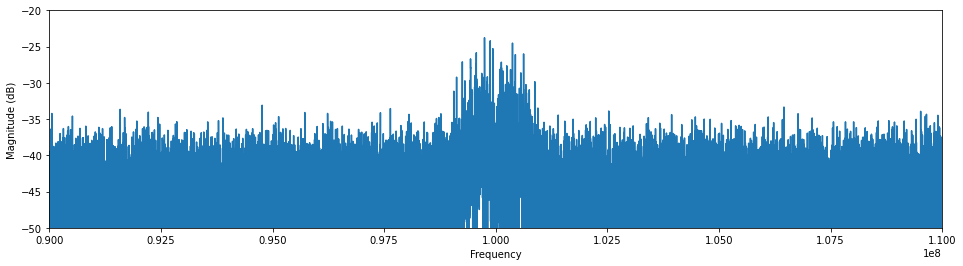

Demodulating...


In [20]:
test(SNR=10.0, num_pkts=2, pkt_len=8, max_delay=10000)

Sending b'c=\x1a{9\x91\x9f|'
Sending b'\x12\xa1\xb3G\xb2%v\xe4'


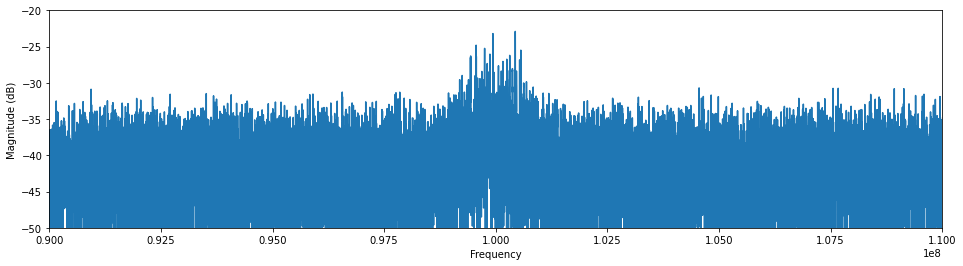

Demodulating...
Found! b'c=\x1a{9\x91\x9f|'
Found! b'\x12\xa1\xb3G\xb2%v\xe4'


In [21]:
test(SNR=7.0, num_pkts=2, pkt_len=8, max_delay=10000)

Sending b'\xe1\x96\x8f\xb8\xcd\x8b\xfdD'
Sending b'\xea\xfb\x13I\x82\x0c\xce8'


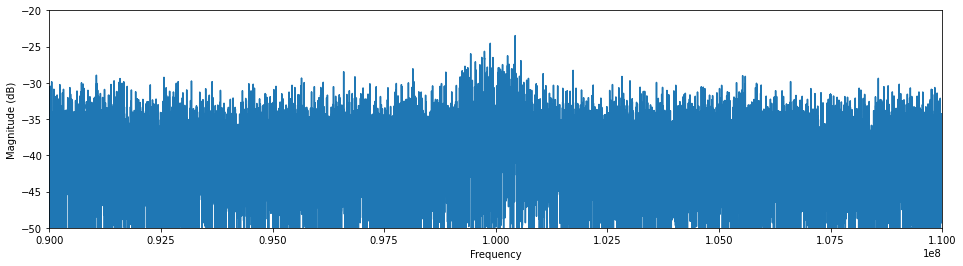

Demodulating...
Found! b'\xe1\x86\x8f\xb8\xcd\x86\xfdD'
Found! b'\xea\xfb\x13I\x82\x0c\xce8'


In [22]:
test(SNR=5.0, num_pkts=2, pkt_len=8, max_delay=10000)

References:
- https://www.mathworks.com/help//comm/ug/end-to-end-ieee-802-15-4-phy-simulation.html

MATLAB has a 802.15.4 simulator which we used to generate the following packets. They only provide the I/Q raw signals, so we must I/Q modulate to RF. Their definition of SNR is about 2-3dB higher than ours.

Based on a relatively small sample size, our BER at an SNR of 8dB (5-6dB w/ MATLAB's definition) is about 10% and near zero at 10dB. The MATLAB script has 10% BER at around -5dB SNR which means our performance is over 10dB worse than it should be. There are a variety of factors for this, including but not limited to ADC resolution, ADC sample rate, FixedPoint resolution, algorithm, and modeling errors.

In [23]:
def rf_iq_mod(I, Q, fs, ps=0):
    # upsample
    n_samples = int(len(I)*FS_CR/fs)
    I = np.kron(I, np.ones(n_samples//len(I)))
    Q = np.kron(Q, np.ones(n_samples//len(Q)))
    
    # generate LO
    dt = 1/FS_CR
    ts = np.r_[0:n_samples]*dt
    I_LO = np.sin(2*np.pi*F_CR*ts - ps)
    Q_LO = np.sin(2*np.pi*F_CR*ts - np.pi/2 - ps)
    
    # mix
    sig = I*I_LO + Q*Q_LO
    
    return ts, sig

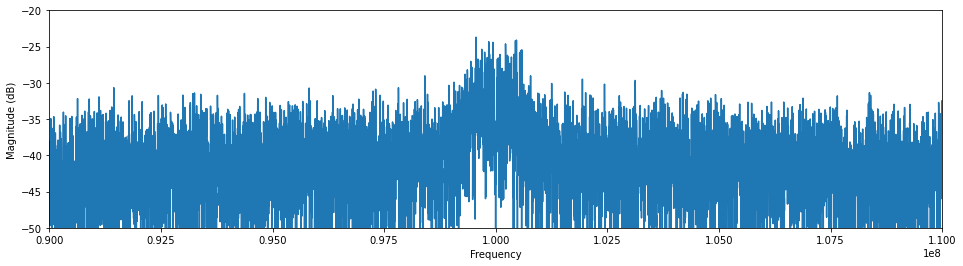

b'\x9b[\xdeWX\x8c\x1b\xd5' [b'\x9b[\xdeWX\x8c\x1b\xd5']


In [24]:
data = np.packbits((np.genfromtxt("packets/matlab_msg.csv", delimiter=",") > 0.5)[::-1]).tobytes()[::-1]
raw  = np.genfromtxt("packets/matlab_sig_5dB.csv", delimiter=",", dtype=np.complex128)

ts, sig = rf_iq_mod(raw.real, raw.imag, 32 * 1e6) # SPC=32
sig = np.hstack((np.zeros(5000), sig, np.zeros(5000))) # zero-pad a bit

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-10e6,F_CR+10e6])
plt.ylim([-50, -20])
plt.show()

print(data, lrwpan_demod(sig, ps=0))

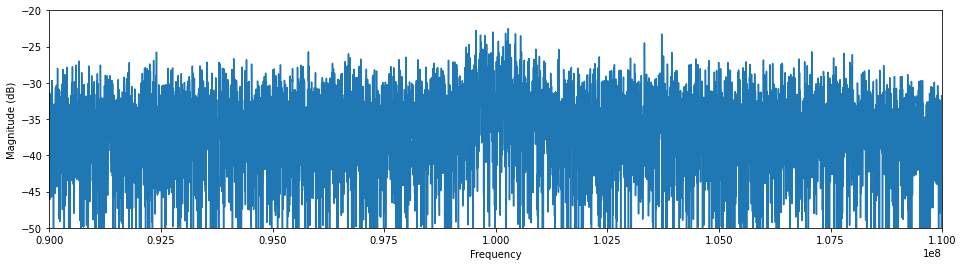

b'\x9b[\xdeWX\x8c\x1b\xd5' []


In [25]:
data = np.packbits((np.genfromtxt("packets/matlab_msg.csv", delimiter=",") > 0.5)[::-1]).tobytes()[::-1]
raw  = np.genfromtxt("packets/matlab_sig_0dB.csv", delimiter=",", dtype=np.complex128)

ts, sig = rf_iq_mod(raw.real, raw.imag, 32 * 1e6) # SPC=32
sig = np.hstack((np.zeros(5000), sig, np.zeros(5000))) # zero-pad a bit

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-10e6,F_CR+10e6])
plt.ylim([-50, -20])
plt.show()

print(data, lrwpan_demod(sig, ps=0))